In [1]:
%run ../ipynb_util.py

https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html

In [2]:
import datasets
import pandas as pd
import transformers

import shap

# load the emotion dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

/home/dvdblk/dev/_thesis/venv/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True, padding="max_length", max_length=512
)
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion",
).cuda()

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    padding="max_length",
    max_length=512,
    tokenizer=tokenizer,
    device=0,
    top_k=None
)

tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
p = lambda x: pred(x, **tokenizer_kwargs)

In [5]:
explainer = shap.PartitionExplainer(pred, masker=tokenizer, output_names=["sadness", "joy", "love", "anger", "fear", "surprise"])

In [6]:
data

,text,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [7]:
pred(data["text"][0])

[[{'label': 'sadness', 'score': 0.9964079260826111},
  {'label': 'anger', 'score': 0.0012332077603787184},
  {'label': 'joy', 'score': 0.0006807033787481487},
  {'label': 'love', 'score': 0.0006490044179372489},
  {'label': 'fear', 'score': 0.0006467572529800236},
  {'label': 'surprise', 'score': 0.0003823298611678183}]]

In [8]:
shap_values = explainer(["I am very happy", "I am very sad"])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [9]:
shap.plots.text(shap_values)

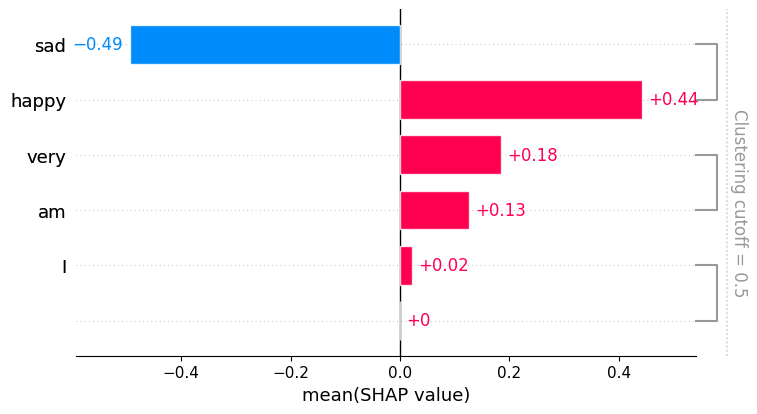

In [10]:
shap.plots.bar(shap_values[:, :, 1].mean(0))

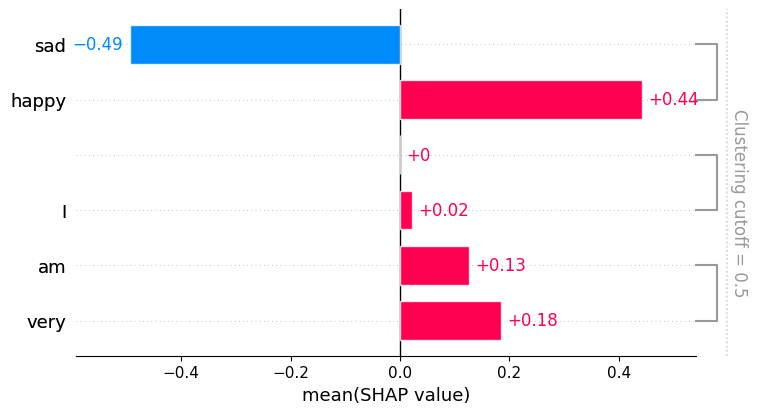

In [11]:
shap.plots.bar(shap_values[:, :, "joy"].mean(0), order=shap.Explanation.argsort)

In [12]:
shap_values.shape

(2, 6, 6)

In [13]:
shap_values[0].shape

(6, 6)

In [14]:
# Function to pad shap values to ensure they have a consistent shape
def pad_shap_values(shap_values, desired_shape):
    """
    Pads the shap values to ensure they have a consistent shape.

    Args:
        shap_values (List[np.ndarray]): List of shap value arrays.
        desired_shape (tuple): The desired shape of the output array.

    Returns:
        np.ndarray: Numpy array of padded shap values.
    """
    padded_shap_values = []
    for array in shap_values:
        padding = [(0, max(0, desired_shape[dim] - array.shape[dim] if dim < len(array.shape) else desired_shape[dim])) for dim in range(len(desired_shape))]
        padded_array = np.pad(array, padding, mode='constant')
        padded_shap_values.append(padded_array)

    return np.stack(padded_shap_values)

padded_shap_values = pad_shap_values(shap_values.values, (40, 6))

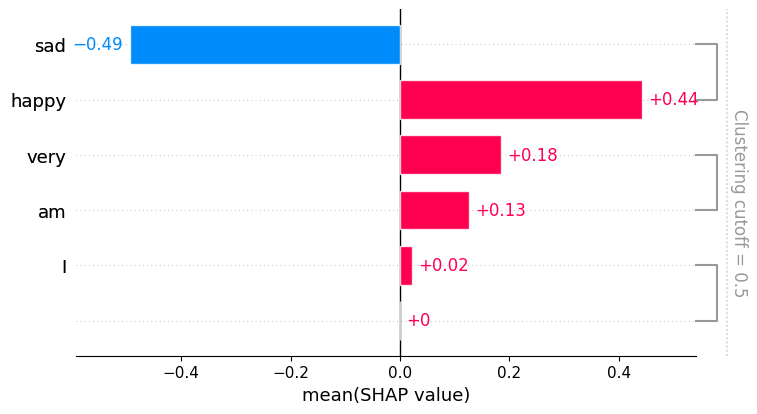

In [15]:
from copy import deepcopy
a = deepcopy(shap_values)
a.values = padded_shap_values

shap.plots.bar(a[:, :, 1].mean(0))